# Data import and exploration
This notebook goes through data import and exploration using Numpy. You could also use Pandas to work with this data,
but it's not very well suited to image data. Regardless of which approach you choose, at some point you'll need to 
efficiently manipulate the images, and. Pandas is really good for tabular data, though,
and we'll use Pandas here to get some descriptive statistics about our target values (energies and positions).

## First, look at the data
Sean Liddick provided information about how the file is formatted:

The file contains one event per line, including the event energies and positions.
The values are space-separated. The first 256 values correspond to the 16x16 detector image, flattened. 
The next values are, in order:
Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2
There are two types of events in the dataset. Single and double.\
For single events Xpos2 and Ypos2 are set to -100 instead of 0 to make a clear distinction.\
The energy units are MeV, and the position units are in pixels.

Open up the file and look at it. In most linux terminals you can also use the command
`head` to display a set number of lines from the start of the file. We'll start with the first line.
Usually you will also have some information about the file formatting.
You can run shell commands inside the notebook by starting the line with an exclamation mark.

In [1]:
!head -1 ../data/CeBr10k_1.txt

53 81 96 117 175 194 229 221 179 112 112 80 74 51 36 29 73 92 140 187 253 385 480 395 298 221 145 101 73 59 52 43 64 131 165 261 405 760 1161 864 458 275 180 101 97 68 60 41 79 126 171 287 654 1808 4037 2244 759 350 197 133 86 78 58 35 75 130 153 324 731 2248 6480 3036 889 358 170 116 105 101 65 39 67 127 171 270 559 1158 1840 1324 618 287 172 103 104 78 75 39 48 95 120 185 366 485 628 496 360 213 152 111 90 70 69 36 58 73 109 149 157 229 280 268 243 172 142 106 81 73 73 40 44 66 88 115 126 148 125 156 118 127 122 119 103 108 87 73 34 49 68 71 104 112 117 107 100 108 128 138 172 134 142 93 37 46 54 52 66 67 88 91 98 109 151 210 284 309 234 144 22 47 43 56 69 63 63 68 109 113 177 372 743 781 429 228 18 34 42 42 40 59 57 76 70 118 220 541 1633 1769 543 230 32 33 36 46 42 46 56 64 74 93 207 435 935 957 501 204 12 34 28 38 37 35 45 59 82 98 154 251 343 393 256 173 13 21 27 34 36 37 27 35 42 63 109 144 162 191 136 115 0.942514 4.30804 6.70703 0.33576 12.6208 13.0421


That last bit of information indicates that the event we printed above is a double event.
We also note that the 256 "pixel" values in the detector image are integers, while the remaining
6 values for energy and position are floats.

## Data import
This is a bit of a "hands-on" approach that focuses on using base functions in python and
Numpy to read the file and create some arrays we can work with.
Reading the file is pretty straightforward, but some challenges appear when the file is large.
We will prepare for that scenario from the get-go.

CeBr10k_1.txt containes 10000 mixed single and double events.\
We set a datapath and filename. Note that we use the 'relative' path to our data, from the
location of the notebook. This works well in a github repo where you control the folder structure.
And if someone else will clone or fork the repo, they don't need to replace the paths.

For small datafiles you can read the entire file into memory, store it as a list where each element is a line in the file, and work from there.
```python
with open(DATA_PATH + fname, "r") as datafile:
    data = datafile.readlines()
```
You now have a list `data` containing all the lines in the file. Using the `with` statement is a shortcut so
we don't need to manually close the file after opening it.
However, reading the entire file into memory might not be possible, so we will read it line by line instead,
looping over the file. This read only one line into memory at a time.

Some resources for this exercise
* [Python I/O File handling](https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files)
* [Numpy array indexing](https://numpy.org/doc/1.18/reference/arrays.indexing.html)
* [Numpy's fromstring() function](https://numpy.org/doc/1.18/reference/generated/numpy.fromstring.html)

In [2]:
# Import the numpy module
import numpy as np

In [3]:
# Set path to data and filename. You can also store it a single variable
# DATA_PATH = "../data/CeBr10k_1.txt" if you prefer. Here we expect to use at least the path itself later,
# so we separate them.
DATA_PATH = "../data/"
fname = "CeBr10k_1.txt"

In [4]:
# Lists to store each image, energy, position, and labels. We know the filesize, so we could create
# arrays that perfectly match the data, but let's assume we don't know how many lines we're going to
# read. 
images = []
energies = []
positions = []
labels = []

# Open the file
with open(DATA_PATH + fname, "r") as datafile:
    # Loop over the file, line by line
    for line in datafile:
        
        # The line is still a string when read from the file. We use numpys fromstring()
        # to convert the line to a numpy array, specifying that each element is separated
        # by a space. This does not convert the line in the file, only the "copy" that we have
        # read into memory. fromstring() also removes any trailing newline ('\n') characters
        # so we don't have to worry about that. The values will be interpreted as floats.
        line = np.fromstring(line, sep=' ')
        
        # Now we pick slices of the array. The first 256 elements are 'pixels' of the detector image
        image = line[:256]
        
        # Get the two energies, at index 256 and 259.
        energy = np.array((line[256], line[259]))
        
        # And the four position values
        pos = np.array((line[257], line[258], line[260], line[261]))

        # Set label for the event. If Energy2 is 0 it is a single event. Any other values corresponds 
        # to a double event. We label single events as type 0, and doubles as type 1. We could also 
        # use Xpos2 or Ypos2 for this purpose.
        if energy[1] == 0:
            label = 0
        else:
            label = 1

        # Finally, we take the separated arrays and add them to their respective "storage" lists.
        images.append(image)
        energies.append(energy)
        positions.append(pos)
        labels.append(label)

        
# We've now looped over the entire file. The only thing that remains is to convert the lists
# to numpy arrays.
images = np.array(images)
energies = np.array(energies)
positions = np.array(positions)
labels = np.array(labels)

In [5]:
# We print the shape of the arrays we've made as a quick check using
# the shape property of numpy arrays.
print("Images shape:", images.shape)
print("Energies shape:",energies.shape)
print("Positions shape:", positions.shape)
print("Labels shape:", labels.shape)

Images shape: (10000, 256)
Energies shape: (10000, 2)
Positions shape: (10000, 4)
Labels shape: (10000,)


The output above tells us that we've got 10000 images, each of length 256, as well as two energy values for each image, and four positions. The images, energies, and positions arrays have two dimensions, while the labels array
only has one.

## Inspection of imported data
If possible, it's usually a good idea to have a look at the data to confirm that
the import gives a correct representation. In this case we want to check that the
images look reasonable and match with positions and label.

Resources:
* [Matplotlib tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html)

In [6]:
print("Label of image 0:", labels[0])
print("Positions:", positions[0])
print("Energies:", energies[0])
print("\nLabel of image 1:", labels[1])
print("Positions:", positions[1])
print("Energies:", energies[1])

Label of image 0: 1
Positions: [ 4.30804  6.70703 12.6208  13.0421 ]
Energies: [0.942514 0.33576 ]

Label of image 1: 0
Positions: [  12.7629     1.52259 -100.      -100.     ]
Energies: [0.302704 0.      ]


So we have two events. One double event and one single event.
We can plot the detector images using matplotlib.

In [7]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Pixel intensity')

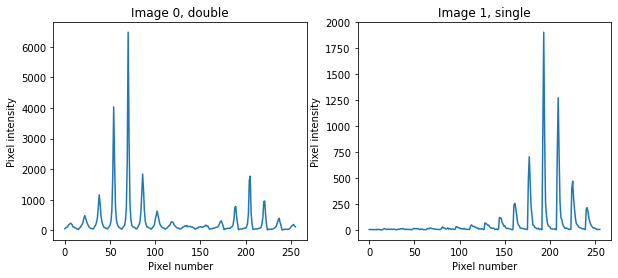

In [8]:
# Plot the two pixel arrays side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(images[0])
ax[0].set_title("Image 0, double")
ax[0].set_xlabel("Pixel number")
ax[0].set_ylabel("Pixel intensity")

ax[1].plot(images[1])
ax[1].set_title("Image 1, single")
ax[1].set_xlabel("Pixel number")
ax[1].set_ylabel("Pixel intensity")

The plots above don't look like images, but we can still see a difference between them. 
Image 0 looks like it has two peaks, while image 1 looks like it only has one. 
This, however, is just one way to plot the detector image. Let's plot it like an actual image 
(or matrix), the way the detector is set up.

By default, the color of each pixel in the following plot is related to the pixel's value,
but the value itself isn't displayed. So we're going to add a "colorbar" to each image that gives
us that information. Additionaly, we will plot the position of the events as a red "x", to see if it matches.

Note that the indices of the positions will be swapped when we plot. This is because imshow uses matrix indexing
when plotting, so it's row-major, or (y, x) instead of (x, y).
In our data, a single image is currently just a flat array of pixels. To plot it as an image, we must reshape it.
This is a simple task when it's a numpy array, using a built-in function for arrays called "reshape". We will
reshape the image to 16x16 pixels. By default, the first 16 values of the array will be row 0, value 17-32 will be row 1 and so on.

Convention in this case is to plot the detector image with origins in the lower left, like a standard coordinate
system. (This can be different from research group to research group). We specify this by passing the keyword "origin" to imshow. 

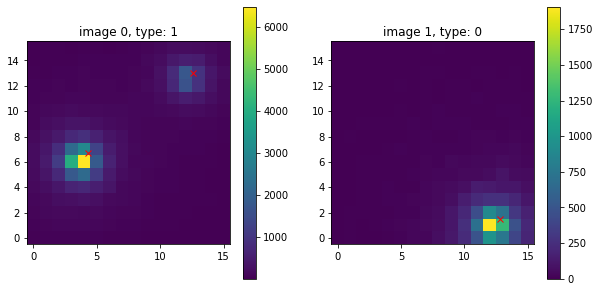

In [9]:
# Plot detector image, including positions and a colorbar.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image_0 = ax[0].imshow(images[0].reshape((16, 16)).T, origin='lower')
ax[0].plot(positions[0, 0], positions[0, 1], 'rx')
ax[0].plot(positions[0, 2], positions[0, 3], 'rx')
ax[0].set_title("image 0, type: " + str(labels[0]))
fig.colorbar(image_0, ax=ax[0])

image_1 = ax[1].imshow(images[1].reshape((16, 16)).T, origin='lower')
ax[1].set_title("image 1, type: " + str(labels[1]))
ax[1].plot(positions[1, 0], positions[1, 1], 'rx')
fig.colorbar(image_1, ax=ax[1])

This looks pretty good. the left image has two clearly visible peaks, while the right image only has one,
as expected. Looking at the values we printed above:
```
Label of image 0: 1
Positions: [ 4.30804  6.70703 12.6208  13.0421 ]
Energies: [0.942514 0.33576 ]

Label of image 1: 0
Positions: [  12.7629     1.52259 -100.      -100.     ]
Energies: [0.302704 0.      ]
```
For image one the positions fits the peak

## Looking further into the detector images
From the pixel intensities above we can see that there's quite some difference in
intensity. This may affect the model's ability to learn. We delve a little deeper into the numbers, 
by checking the maximum, minimum, and mean pixel intensity.

In [10]:
p_max = np.amax(images)
p_min = np.amin(images)
p_mean = np.mean(images)
print("Image max:", p_max)
print("Image min:", p_min)
print("Image mean:", p_mean)

Image max: 9951.0
Image min: 0.0
Image mean: 157.71130703125


### Descriptive statistics with Pandas
We're just going to import the energy and positions columns and get some quick statistics about them.
This can also be done with [SciPy's stats module](https://docs.scipy.org/doc/scipy/reference/stats.html).

In [11]:
import pandas as pd

You've probably seen Morten's example with the nuclear binding energies. A great example of a strictly formatted file
where you can specify column widths and let pandas do the rest. Here, we don't have specific column widths, but we
do have a specific column separator - spaces.

Resources
* [Pandas' read_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html)
* [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html)
* [Pandas' DataFrame.describe()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)

In [12]:
# We already have the data path and filename
# Pandas expect the first line to be headers, but we have no headers, so we specify it to be None.
# We also set all values to the type np.float32
#columns = [256, 257, 258, 259, 260, 261]
#df = pd.read_table(DATA_PATH + fname, sep=' ', header=None, dtype=np.float32, usecols=columns)
df = pd.read_table(DATA_PATH + fname, sep=' ', header=None, dtype=np.float32)
# We can rename the positions and energy columns to keep that correct
df.rename(
    columns={
        256: 'Energy1',
        257: 'Xpos1',
        258: 'Ypos1',
        259: 'Energy2',
        260: 'Xpos2',
        261: 'Ypos2'
        },
    inplace=True
)
# Output stats for the columns with energies and positions.
stat_columns = ['Energy1', 'Energy2', 'Xpos1', 'Ypos1', 'Xpos2', 'Ypos2']
df[stat_columns].describe()

,Energy1,Energy2,Xpos1,Ypos1,Xpos2,Ypos2
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.503784,0.247578,7.989531,7.980563,-46.006119,-46.041538
std,0.289041,0.320705,4.217268,4.252015,54.100166,54.064831
min,0.000097,0.000000,0.669378,0.667048,-100.000000,-100.000000
25%,0.251697,0.000000,4.354045,4.336565,-100.000000,-100.000000
50%,0.510705,0.000000,8.003125,7.935515,-100.000000,-100.000000
75%,0.751691,0.494104,11.548125,11.705625,8.039598,7.981738
max,0.999913,0.999863,15.332200,15.328700,15.330700,15.331400


Looking over the numbers, the mean values for Energ2, Xpos2, and Ypos2 seem off.
The reason is that we haven't separated the data into single events and double events.
Recall that for single events, Energy2 is set to 0, and Xpos2 and Ypos2 are both set to -100.
We need to separate the two types of events.

To do this we can use a boolean expression to extract only the rows we want to look at. We'll use the
position this time around.

In [13]:
singles = df['Xpos2'] == -100
doubles = df['Xpos2'] != -100

Now we're going to sort of 'double-index' the dataframe. The first index gives us a dataframe
that only shows the rows containing single events. The second index specifies which columns we want to see.
The order of the indices is not important.

In [14]:
# Output statistics for single events
df[singles][stat_columns].describe()

,Energy1,Energy2,Xpos1,Ypos1,Xpos2,Ypos2
count,5002.000000,5002.0,5002.000000,5002.000000,5002.0,5002.0
mean,0.505196,0.0,8.002673,7.985090,-100.0,-100.0
std,0.292676,0.0,4.200381,4.219958,0.0,0.0
min,0.000113,0.0,0.673776,0.667048,-100.0,-100.0
25%,0.247151,0.0,4.415858,4.395275,-100.0,-100.0
50%,0.507744,0.0,8.019080,7.935830,-100.0,-100.0
75%,0.758117,0.0,11.542475,11.643875,-100.0,-100.0
max,0.999913,0.0,15.332200,15.328700,-100.0,-100.0


In [15]:
# Output statistics for double events
df[doubles][stat_columns].describe()

,Energy1,Energy2,Xpos1,Ypos1,Xpos2,Ypos2
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,0.502372,0.495355,7.976377,7.976031,8.030966,7.960112
std,0.285380,0.288175,4.234482,4.284275,4.211559,4.212573
min,0.000097,0.000189,0.669378,0.667362,0.666759,0.668009
25%,0.257341,0.250011,4.271335,4.282320,4.406513,4.278280
50%,0.513196,0.494276,7.997455,7.934830,8.048775,7.983100
75%,0.741211,0.744490,11.550850,11.737025,11.662975,11.514900
max,0.999753,0.999863,15.331300,15.327100,15.330700,15.331400


Now this looks alot more reasonable. The mean energy is centered between the minimum and maximum, and the
mean positions looks to be in the middle of the picture.

## Separate and save the data
First, we separate the data into a *training set* and a *test set*. The test set will be used to give us an "out-of-sample"
accuracy. To do this properly, the model will never see the test set in any way, shape, or form before we've trained, evaluated, and optimized it as far as we'd like to go. In other words, we use the training set to make the model as good as possible, and only then do we predict on the test set and report out-of-sample metrics.

You can do the splitting of data manually by slicing the arrays, but scikit-learn has it's own function for doing this,
[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split).
Instead of creating copies of the dataset, filling up often precious memory, we will work with indices that we
pass around. This also makes it easier to trace any results back to the original inputs.

### Numpy format

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Indices for all data
x_idx = np.arange(images.shape[0])

# Split the indices into training and test sets (take out 10% of the data as test)
train_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.1)

# Save the training and test data in the data folder
# We also need to save the labels, energies, and positions. This allows us to
# quickly load it if we need it.

# Save the training data. np.save adds a ".npy" file extension to the provided filename.
# We save the files in the same folder as the original datafile.
np.save(DATA_PATH + "images_training", images[train_idx])
np.save(DATA_PATH + "energies_training", energies[train_idx])
np.save(DATA_PATH + "positions_training", positions[train_idx])
np.save(DATA_PATH + "labels_training", labels[train_idx])

# Save the test data
np.save(DATA_PATH + "images_test", images[test_idx])
np.save(DATA_PATH + "energies_test", energies[test_idx])
np.save(DATA_PATH + "positions_test", positions[test_idx])
np.save(DATA_PATH + "labels_test", labels[test_idx])

You could also opt to store the entire training and test sets as two files, by concatenating them.
This is just personal preference.

### hdf5 format

In [18]:
import h5py

In [19]:
# Open separate files for saving training and test datasets
data_training = h5py.File(DATA_PATH + "data_training.hdf5", "w")
data_test = h5py.File(DATA_PATH + "data_test.hdf5", "w")

# Training data
data_training.create_dataset('images', data=images[train_idx])
data_training.create_dataset('energies', data=energies[train_idx])
data_training.create_dataset('positions', data=positions[train_idx])
data_training.create_dataset('labels', data=labels[train_idx])
data_training.close()

# Test data
data_test.create_dataset('images', data=images[test_idx])
data_test.create_dataset('energies', data=energies[test_idx])
data_test.create_dataset('positions', data=positions[test_idx])
data_test.create_dataset('labels', data=labels[test_idx])
data_test.close()